# Exploring the NHANES diabetes data

[DSLC stages]: EDA


You can conduct an EDA of the NHANES diabetes dataset in this document.

In [2]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

data_States = pd.read_csv('data_States.csv')
data_register = pd.read_csv('data_register.csv')
data_income = pd.read_csv('data_income.csv')
data_noVote = pd.read_csv('data_noVote.csv')

In [31]:
from scipy.stats import ttest_rel, t
import pandas as pd
import numpy as np

# Assuming train_data contains columns starting with "PRE_" and "POST_", and "weights"
pre_columns = [col for col in train_data.columns if col.startswith("PRE_")]
post_columns = [col for col in train_data.columns if col.startswith("POST_")]

# Match PRE and POST columns (ignoring "PRE_" and "POST_" prefixes)
pre_post_pairs = {
    pre: pre.replace("PRE_", "POST_") for pre in pre_columns if pre.replace("PRE_", "POST_") in post_columns
}

# Prepare a DataFrame to store test results
results = []

# Compare each PRE-POST pair
for pre_col, post_col in pre_post_pairs.items():
    pre_data = train_data[pre_col]
    post_data = train_data[post_col]
    weights = train_data['weights'].loc[pre_data.index]  # Align weights with data
    
    # Ensure equal length for paired testing
    paired_data = pd.DataFrame({
        "pre": pre_data,
        "post": post_data,
        "weights": weights
    }).dropna()
    
    pre_values = paired_data["pre"].astype(float)
    post_values = paired_data["post"].astype(float)
    weights = paired_data["weights"].astype(float)
    n = len(pre_values)  # Sample size
    
    # **Unweighted Tests**
    try:
        unweighted_t_stat, unweighted_p_value = ttest_rel(pre_values, post_values)
        unweighted_test_type = "t-test"
        
        # Calculate confidence intervals for unweighted test
        unweighted_mean_diff = post_values.mean() - pre_values.mean()
        unweighted_std_dev_diff = (post_values - pre_values).std()
        unweighted_se_diff = unweighted_std_dev_diff / np.sqrt(n)
        unweighted_t_critical = t.ppf(1 - 0.05 / 2, df=n - 1)
        unweighted_ci_lower = pre_values.mean() - unweighted_t_critical * unweighted_se_diff
        unweighted_ci_upper = pre_values.mean() + unweighted_t_critical * unweighted_se_diff
        
    except ValueError:
        # If t-test fails, default to Wilcoxon (non-parametric)
        unweighted_t_stat, unweighted_p_value = wilcoxon(pre_values, post_values)
        unweighted_test_type = "Wilcoxon"
        unweighted_ci_lower, unweighted_ci_upper = None, None  # CI not computed for Wilcoxon

    # **Weighted Tests**
    diff = post_values - pre_values
    weighted_mean_diff = np.sum(weights * diff) / np.sum(weights)
    weighted_var_diff = np.sum(weights * (diff - weighted_mean_diff) ** 2) / np.sum(weights)
    weighted_se_diff = np.sqrt(weighted_var_diff / n)  # Weighted standard error
    weighted_t_stat = weighted_mean_diff / weighted_se_diff
    df = n - 1  # Degrees of freedom

    # Calculate p-value (two-tailed test)
    weighted_p_value = 2 * (1 - t.cdf(np.abs(weighted_t_stat), df))

    # Calculate confidence intervals for weighted test
    weighted_t_critical = t.ppf(1 - 0.05 / 2, df)
    weighted_ci_lower = pre_values.mean() - weighted_t_critical * weighted_se_diff
    weighted_ci_upper = pre_values.mean() + weighted_t_critical * weighted_se_diff

    # Store results
    results.append({
        "Variable": pre_col.replace("PRE_", ""),
        "PRE_Mean_Unweighted": pre_values.mean(),
        "POST_Mean_Unweighted": post_values.mean(),
        "PRE_Mean_Weighted": (pre_values * weights).sum() / weights.sum(),
        "POST_Mean_Weighted": (post_values * weights).sum() / weights.sum(),
        "Unweighted_Test_Type": unweighted_test_type,
        "Unweighted_Mean_Difference": unweighted_mean_diff,
        "Unweighted_CI_Lower": unweighted_ci_lower,
        "Unweighted_CI_Upper": unweighted_ci_upper,
        "Unweighted_T_Statistic": unweighted_t_stat,
        "Unweighted_P_Value": unweighted_p_value,
        "Weighted_Mean_Difference": weighted_mean_diff,
        "Weighted_CI_Lower": weighted_ci_lower,
        "Weighted_CI_Upper": weighted_ci_upper,
        "Weighted_T_Statistic": weighted_t_stat,
        "Weighted_P_Value": weighted_p_value
    })

# Convert results to a DataFrame
comparison_results = pd.DataFrame(results)

# Display significant changes (p-value < 0.05 for weighted and unweighted)
significant_unweighted = comparison_results[comparison_results["Unweighted_P_Value"] < 0.05]
significant_weighted = comparison_results[comparison_results["Weighted_P_Value"] < 0.05]

print("All variables considered\n", comparison_results["Variable"])
print()

print("Significant Changes from Pre to Post (Unweighted):")
print(significant_unweighted[['Variable','PRE_Mean_Unweighted','POST_Mean_Unweighted','Unweighted_P_Value']])

print("\nSignificant Changes from Pre to Post (Weighted):")
print(significant_weighted[['Variable','PRE_Mean_Weighted','POST_Mean_Weighted','Weighted_P_Value']])


All variables considered
 0                    ThermoBiden
1                    ThermoTrump
2                   ThermoHarris
3                    ThermoPence
4                   VoteAccuracy
5     VotePresident_Donald Trump
6     VotePresident_Jo Jorgensen
7    VotePresident_Howie Hawkins
Name: Variable, dtype: object

Significant Changes from Pre to Post (Unweighted):
                      Variable  PRE_Mean_Unweighted  POST_Mean_Unweighted  \
0                  ThermoBiden            49.033471             51.143720   
1                  ThermoTrump            40.681332             39.789855   
2                 ThermoHarris            47.815908             49.429952   
3                  ThermoPence            44.391649             47.275362   
4                 VoteAccuracy             3.074534              2.291063   
5   VotePresident_Donald Trump             0.449448              0.493789   
6   VotePresident_Jo Jorgensen             0.030883              0.010870   
7  VotePresi

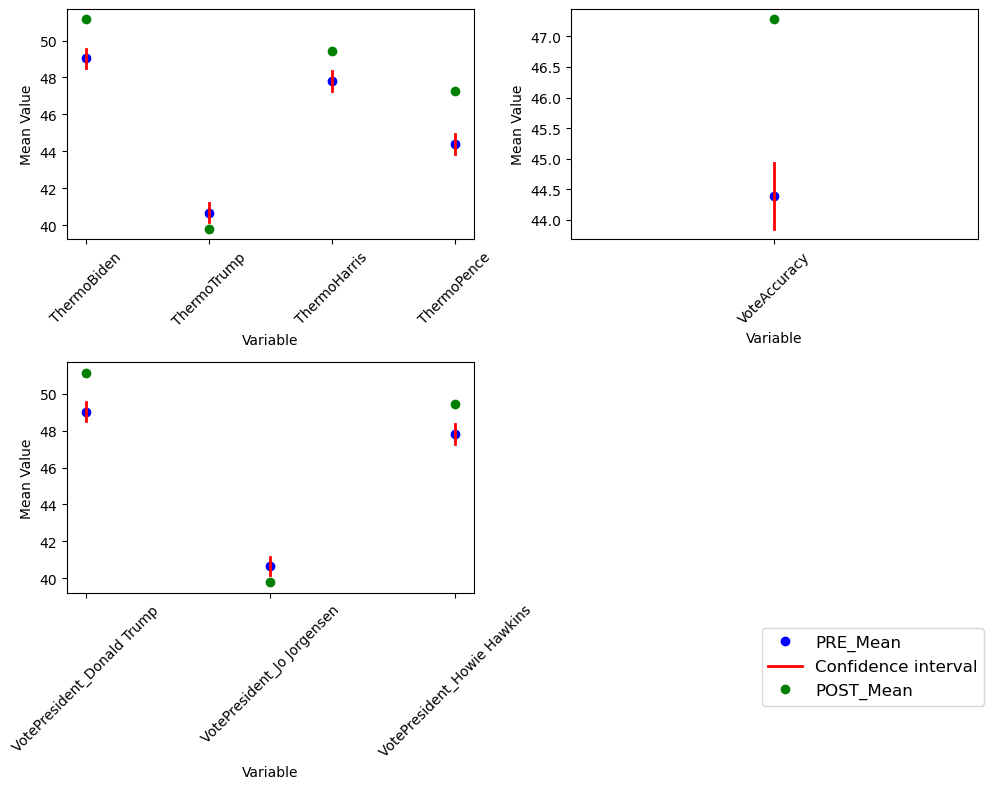

In [57]:
import matplotlib.pyplot as plt

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Track whether the label has been added to avoid duplicates
labels_added = {'PRE_Mean': False, 'POST_Mean': False, 'Confidence interval': False}

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(unweighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean only if label hasn't been added
    if not labels_added['PRE_Mean']:
        ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', label='PRE_Mean', color='blue')
        labels_added['PRE_Mean'] = True
    else:
        ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue')
    
    # Add confidence interval lines only if label hasn't been added
    if not labels_added['Confidence interval']:
        ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', label='Confidence interval', lw=2)
        labels_added['Confidence interval'] = True
    else:
        ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', lw=2)
    
    # Plot the points for POST_Mean only if label hasn't been added
    if not labels_added['POST_Mean']:
        ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', label='POST_Mean', color='green')
        labels_added['POST_Mean'] = True
    else:
        ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green')

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = unweighted_data["Variable"][4]

# Plot the points for PRE_Mean only if label hasn't been added
if not labels_added['PRE_Mean']:
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', label='PRE_Mean', color='blue')
    labels_added['PRE_Mean'] = True
else:
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue')

# Add confidence interval lines only if label hasn't been added
if not labels_added['Confidence interval']:
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', label='Confidence interval', lw=2)
    labels_added['Confidence interval'] = True
else:
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', lw=2)

# Plot the points for POST_Mean only if label hasn't been added
if not labels_added['POST_Mean']:
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', label='POST_Mean', color='green')
    labels_added['POST_Mean'] = True
else:
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][5:]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean only if label hasn't been added
    if not labels_added['PRE_Mean']:
        ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', label='PRE_Mean', color='blue')
        labels_added['PRE_Mean'] = True
    else:
        ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue')

    # Add confidence interval lines only if label hasn't been added
    if not labels_added['Confidence interval']:
        ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', label='Confidence interval', lw=2)
        labels_added['Confidence interval'] = True
    else:
        ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], color='red', lw=2)

    # Plot the points for POST_Mean only if label hasn't been added
    if not labels_added['POST_Mean']:
        ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', label='POST_Mean', color='green')
        labels_added['POST_Mean'] = True
    else:
        ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green')

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[3].axis('off')

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


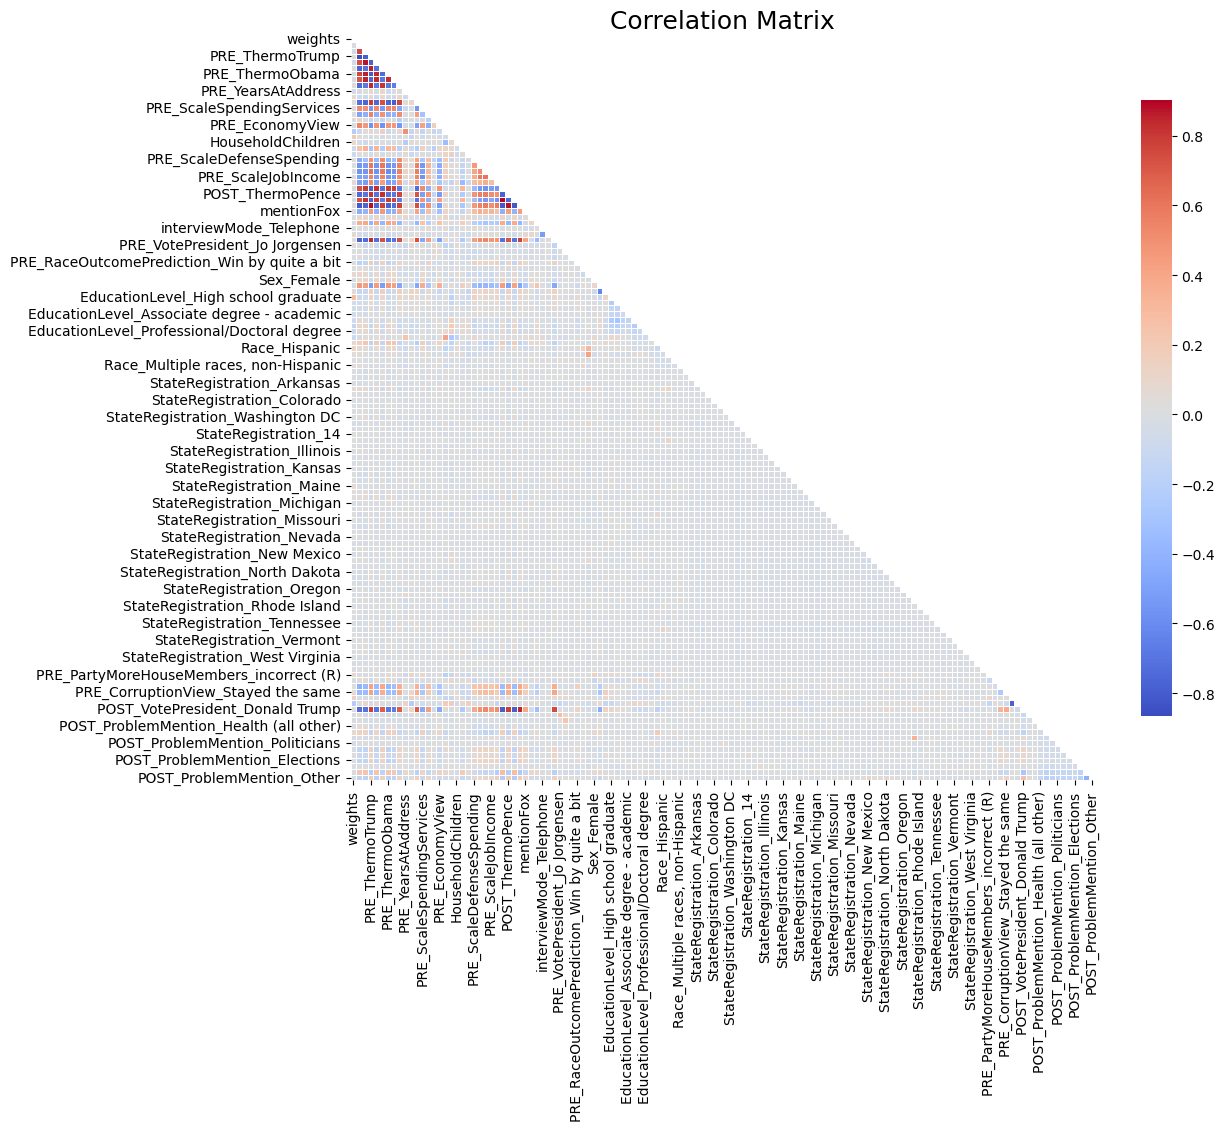

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix =  train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('Correlation Matrix Heat Map')
plt.show()

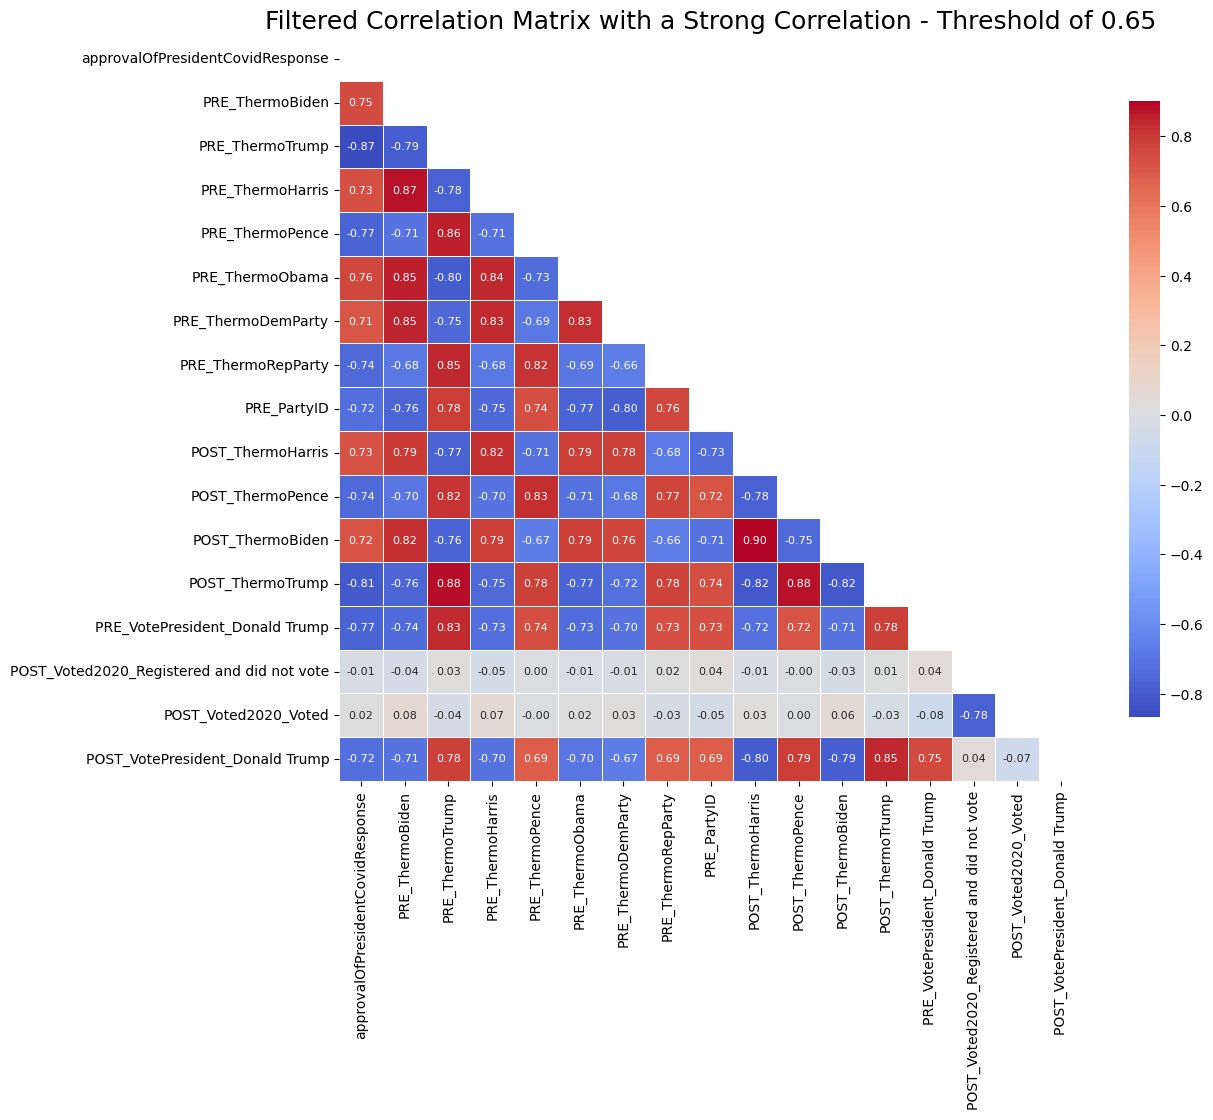

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.65

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=True,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

In [16]:
import importlib
# Import the function
from functions import EDA_helper

# Reload the module to reflect any updates
importlib.reload(EDA_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_data = [EDA_helper.perturb_dataframe(train_data) for i in range(50)]

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.48873888 4.60744951 3.45241474 ... 0.71328684 2.21994444 3.59161494]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[40.37115914 17.73292364 54.91250889 ... 76.1472877  72.26245143
 85.67857056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.47866078 0.70642099 4.49318716 ... 4.30345341 0.74570245 3.36710165]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[81.9412091  71.90348524 88.91228424 ...  5.97818855  3.74149167
  4.67769887]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.58586275 1.99067532 4.58389371 ... 3.68285876 0.6513622  3.44703392]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.60252099 19.97863304 72.18393306 ... 13.25285605  9.79854845
 90.17623484]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.1599693   1.10865522 -0.08699518 ...  0.14545953 -0.13251572
 -0.14061423]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.08123392  0.18196971 -0.03191201 ...  1.0045253   1.16701747
  0.97279056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.11928738  0.88336088 -0.06372732 ... -0.13741749 -0.15979592
 -0.11808156]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.05028389 -0.13712643  0.98381192 ...  0.9181481  -0.14411893
 -0.01263429]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[90.21210274 78.28958178 80.54821269 ... -5.27381848  8.42350296
 60.56793276]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 96.50399991  -0.89542906 116.56883958 ...  15.25334504  34.32224542
 106.70997302]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.85736036 5.86338703 1.14028956 ... 5.58078841 3.27196784 4.9228948 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.99166288 1.79633197 2.66718286 ... 1.90092116 2.45328238 1.83099727]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.54320348 2.83605877 1.63178127 ... 2.77397816 0.91856353 6.12290534]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.83224297 7.57491059 1.85848151 ... 4.56683594 1.66944825 3.08519561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.00971168 -0.09078344 19.15825589 ... 23.93443864 11.53406839
 17.01573657]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.27278015  0.03045354  0.56401945 ...  0.44442874 -0.08050982
 -0.17347103]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.7813908  7.37198386 3.2802481  ... 5.59810356 6.21610176 2.01280044]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.51714686 3.15164571 1.49304486 ... 5.18426962 2.76581245 1.44704486]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  2.44514053 109.25874136  31.70418627 ...  -0.56642064  57.46528444
 -16.04873328]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[94.1930885  15.06140837 63.12031861 ... 13.91465086 24.36461939
 69.19353038]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.83790582 4.0263091  3.80589279 ... 2.5258277  4.38874541 3.42586268]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4.45909027 63.49766334 55.52155476 ... 96.37756756 57.85111625
  0.27657475]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 21.95256173  37.30742483   7.53996687 ...  41.36585146  69.76309255
 116.69530388]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 88.25517346  22.16992842   4.07588718 ... -17.85181922  50.19930719
  74.24781637]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.18591384 -0.02050226  0.85473386 ...  0.10605826  0.12024154
  0.23284517]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.64715066 3.71577271 3.45440171 ... 0.82129628 4.54672568 3.60433008]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.3235221  3.25851073 5.38252374 ... 5.2688251  4.10151909 2.28260404]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.90597984 -0.00828606  6.35568615 ...  5.99557605  6.78678393
  3.09220684]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.76279242 2.22671245 5.72875446 ... 7.65387841 5.66567849 0.64535486]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58665435 3.90422384 0.52323416 ... 2.77123279 2.19276979 6.12144067]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 84.09087921  50.71368966  46.37995574 ...  72.25554254  71.25916546
 -11.28849992]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 32.37240311  83.07691181 -16.5338848  ...  79.20657849  69.40823179
  19.03452578]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[110.75680358  35.80281687  83.22022775 ...  76.45137993 -10.49672812
  33.95483323]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[78.53185918 94.59332503 84.96334424 ... 43.71017948 17.56776552
 10.57218421]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[75.66990564 95.7371333  30.24706509 ... 63.75799283  5.86795369
  5.03825158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[69.56159642 79.63644946 83.50914742 ... 40.81234832 36.67184682
 81.17808577]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.07930778  5.11698959 20.25665275 ...  4.25194417 21.49591518
 14.21158397]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.85294415  0.09393001 -0.2063899  ...  0.18417004 -0.29891505
  0.18880978]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.18681558 5.08614672 3.78242466 ... 5.25941456 0.82969826 1.878442  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.74754994 5.38203756 6.19700807 ... 4.08854127 1.91030643 2.73045783]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.78609447 3.44923841 2.80514824 ... 2.2774663  2.81649711 2.03343539]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.84459507 18.26059203 16.75030305 ... 20.31285486  6.80551377
 19.70119898]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -5.1625183   16.01060131  25.58276446 ...  76.40970037  84.87682152
 103.7859596 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.37360757 33.54024918 32.32092487 ... 74.64568805 63.80131047
 98.89569827]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[100.42936287  24.68132249  16.84251114 ...  14.21671589  54.43203856
  96.08895214]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[69.00485337 88.91930521 21.32959347 ... 62.09111451 -1.37907593
 38.56711205]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.2712722  2.19922841 3.77986261 ... 2.66500628 3.58524439 3.64315947]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.84991914  9.17031756 -0.18390048 ... 19.38552958  3.82960135
 23.59113056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9805167  3.61125131 1.58961895 ... 6.39532796 6.73887978 1.04756158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.80326415 5.82503699 3.44943826 ... 5.49135897 5.758032   5.7351525 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.10281266  0.00121765  0.81953931 ...  1.2121528  -0.22416013
  0.22829197]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.03988451 3.38703242 3.98315768 ... 3.40958965 2.34973014 0.76690548]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.92244473 3.03495746 4.08892921 ... 2.96993069 4.15016013 2.17495766]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.75036588 3.84669702 1.7018008  ... 1.68094875 3.82348549 3.84510938]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.93634387 7.10697387 0.66892342 ... 3.80362804 5.1303437  0.49939523]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.74261213 0.86249041 7.59835928 ... 2.10760193 4.70161661 2.82519738]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.43928689  3.81726235 41.54244504 ... 76.21734068 19.86745211
 14.57569158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 29.23717666  35.69906846 110.7027267  ...  68.50108657  63.57899322
  76.47198377]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-5.21814834 72.07706275 51.73712803 ... 60.76413894 43.53319208
  0.79975076]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-4.82672107 73.65639707 91.40010705 ... 80.2524514  14.46140994
 86.89298211]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.22518583 3.97543328 4.20017208 ... 3.73956636 3.62229671 3.56821542]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 54.80012424  -0.34243049  87.42101102 ... 107.47912657  63.58559903
  37.01482152]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 93.6407239    7.57397954  57.20334827 ...  92.07659503  25.49630754
 -14.68793061]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 90.09558583  64.08375047 104.35399893 ...   2.79452935  52.68764487
  11.29130308]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.26401548 2.06146271 3.59231241 ... 1.56365251 1.45481199 2.83010648]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.47572275 43.89603413 86.92626385 ... 70.54139863 29.09496937
 55.05849834]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 50.70825805  71.26974028 -12.50187252 ...  24.46983735  85.31781499
  14.235132  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.98586877 1.80793587 6.69613583 ... 1.13994052 2.11162649 0.21463675]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 12.38371803  13.59656777  66.9298566  ...   0.75642686 107.13363021
 -13.37622197]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[77.38120609 73.98935805 12.05447543 ... -5.41152819 92.74131769
 32.69342806]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.73773968 0.82849847 7.16496401 ... 5.68378099 1.89374975 0.03920778]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.25175674 7.88671713 3.00755152 ... 4.88681735 4.21687693 6.66823488]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.73320477 2.4297825  4.51808882 ... 3.82373815 2.96518555 1.36406507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.86011621 5.27008346 4.79248122 ... 5.01731733 5.14210422 5.20712321]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.44197028 19.56721645 -0.2068996  ... 13.1110533   5.72073301
 14.99550934]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.04329131  1.66403297  0.23797312 ... -0.12656949  0.07648305
  0.01138539]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.71613505 2.39524654 2.79598643 ... 3.95575617 2.09367744 3.2300189 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.59943613 4.08587876 1.82622564 ... 3.85441734 1.52398489 2.46761255]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[61.42124825 38.95323873 56.24043244 ... 92.37642009 26.86155682
  1.0557055 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 7.74059891  6.19881636  0.71008349 ...  8.07043657 -0.00980968
  2.18720262]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.61574616 5.41126562 7.67722588 ... 0.64156984 2.1495585  1.34264566]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90609857 1.98257505 2.13735997 ... 1.61990902 5.9984918  6.31629081]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWa

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[100.65538338  75.54953387  80.54380821 ...  10.62498137 -14.90864205
  97.91529249]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.16816713 11.69656057 69.72134344 ... 72.06207091 14.6756241
 28.77153562]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_hel

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[101.55864161 105.21610038 -11.047266   ...   6.68711399  14.81662262
  84.20942427]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[81.5876713  70.22160996 82.74482252 ... 92.77336499 55.74446158
 12.58047332]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[104.95513709  99.595949    85.44717124 ...  30.43675356   6.00632619
  45.90278648]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 69.33290052  71.556751    61.30219503 ...  14.22993947 -13.81509711
  68.26639779]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[98.18842811 79.47778817  0.397438   ... 16.44705489 61.76231734
 79.89525511]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 35.8783114   15.29202021  82.23863945 ...  11.53532717 -14.45147715
  42.68089291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 94.76505749  16.18950676  96.37453929 ... -13.31455751  35.31231028
  54.21767297]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 31.59786338 118.80031862  77.41304704 ...  95.36209625  66.05323393
   8.86511667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[58.31476997 48.5500327  97.30048035 ... 28.63444044  4.57594225
 26.67645039]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[75.64880608  8.62897006 89.51713551 ...  5.06103839 95.69655818
 19.34176173]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.p

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.45563239 4.23457778 1.48880561 ... 4.19652994 3.7103602  3.73075084]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[92.90658071 53.23137079 68.03281776 ... 53.36652068 80.27577293
  0.83342252]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 71.02250227  95.93481743  48.21874771 ...  72.48291026 -11.57092494
  34.77286576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[86.10614141 41.88074644  5.50662896 ... 14.19071176 59.36038513
 22.24052928]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_he

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.88762021 2.1721152  1.26530486 ... 3.40813421 4.63399291 3.22782134]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[23.43847    90.66826386 68.12268241 ...  4.42907897  3.3980161
 10.85130895]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: Fu

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.50520208 1.11312652 0.97698531 ... 3.44961819 3.69246228 4.07840426]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[37.06338028  5.30689261 82.57914605 ...  7.18575594  3.91463644
 15.47518829]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.1835249  -0.12908622  0.98977095 ...  1.07010134  1.23436118
  0.02210458]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.19379267 3.62082255 3.7910041  ... 3.71615611 1.16527302 3.73887215]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 19.02717464  54.83316628  11.46195474 ...  12.03252415 106.91643145
  21.83711575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.08795741  0.79595096  0.03654191 ...  0.17807355 -0.2178313
 -0.12712757]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_hel

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.04389037 1.16603791 1.18450024 ... 0.1773642  0.99238256 0.16275954]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.16170894 -0.10192162  0.15447921 ...  0.07124939  1.16585534
  0.14447028]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\EDA_helper.py:34: F

In [17]:
perturbed_data

[       weights  approvalOfPresidentCovidResponse  PRE_ThermoBiden  \
 0     0.093433                          1.000000        15.000000   
 1     2.121808                          4.000000        59.881544   
 2     1.169236                          4.000000        70.000000   
 3     1.200427                          4.000000        70.000000   
 4     1.140000                          1.597507         0.000000   
 ...        ...                               ...              ...   
 5791  0.200000                          4.000000        60.000000   
 5792  0.304525                          4.000000       100.000000   
 5793  1.070000                          3.568126        70.000000   
 5794  0.380000                          4.000000        70.000000   
 5795  0.340000                          1.000000         0.000000   
 
       PRE_ThermoTrump  PRE_ThermoHarris  PRE_ThermoPence  PRE_ThermoObama  \
 0          100.000000          0.000000        85.000000        15.000000   
 1